In [3]:
%matplotlib inline


In [5]:
import os
from astropy.io import fits
import pandas as pd
import sys
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
import tarfile
from astropy import units as u 
import lsst.daf.persistence as dafPersist

## This Weeks goal
1. Access HiTS light curve data and plot it for at least one variable object
2. Access LSST light curve data for the same object(s) and plot it too

In [17]:
hitsDataDir= '/epyc/users/mrawls/premap2019/hits-dr1'
hitsFilename= 'HiTS_DR1_variables_DM-dataset-subset.fits'
hitsFilepath = os.path.join(hitsDataDir, hitsFilename)
hitsTable= fits.open(hitsFilepath) #load data as an astropy fits thing
hitsDf= pd.DataFrame(hitsTable[1].data) #turn data into a pandas dataframe
hitsDf.head()#shows us (prints out) what the dataframe looks like
print(len(hitsDf))
#hitsDf.columns  #all of the things we can access from the data 82 columns


165


In [42]:

#Intermediate goal: get something like "Blind15A_40_s17_LC_5-.tar.gz from a row in the dataframe
testRow = hitsDf.iloc[0]
testRow
tok = testRow['internalID'].split('_')
print(tok)
field = '_'.join([tok[0], tok[1]])
print(field)
ccd = tok[2]
lightcurveTestFile= field + '_' + ccd + '_LC_50.tar.gz'
lightcurveTestPath= os.path.join(hitsDataDir, 'light_curves', field, ccd, lightcurveTestFile)
print(lightcurveTestPath)

['Blind15A', '26', 'N1', '1715', '0146']
Blind15A_26
/epyc/users/mrawls/premap2019/hits-dr1/light_curves/Blind15A_26/N1/Blind15A_26_N1_LC_50.tar.gz


In [54]:
def plot_hits(row, lcPath='/epyc/users/mrawls/premap2019/hits-dr1/light_curves'):
    '''Plots light curves from HiTS dr1.
    
    Parameters
    ----------
    row: Pandas dataframe row from DR1 source data 
    lcPath: Path on disk to light curves from DR1'''
    tok = row['internalID'].split('_')
    ccd = tok[2]
    field = '_'.join([tok[0], tok[1]])
    lightcurveFile= field + '_' + ccd + '_LC_50.tar.gz'
    #lightcurvePath= os.path.join(hitsDataDir, 'light_curves', field, ccd, lightcurveTestFile)
    tarball = tarfile.open(os.path.join(lcPath, field, ccd, lightcurveFile))
    data = tarball.extractfile(row['internalID'] + '_g.dat')
    dfl = pd.read_csv(data, sep='\t') # load a file with light curve data into the pandas datafram
    fig = plt.figure (figsize = (6, 4))
    plt.errorbar(dfl.MJD, dfl.MAG_AP1, dfl.MAGERR_AP1, marker='o', linestyle= ':')
    plt.xlabel('Time (MJD)')
    plt.ylabel('magnitude')
    

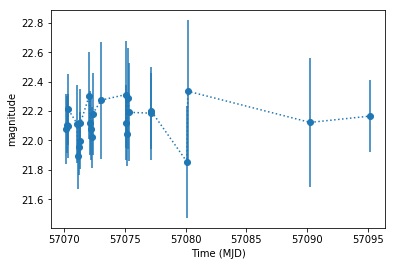

In [56]:
plot_hits(hitsDf.iloc[22])

We made it through part 1 of the goals! We have a function we can use to plot any of the 165 HiTS DR1  variable object light curves. We'll pick up from here next time to do part 2 of our goals